## 02 – Análise Exploratória de Dados (EDA)

**Objetivo:**  
Explorar os padrões temporais e espaciais dos focos de queimadas em MA (jan–jun/2025) e gerar insights iniciais que irão alimentar o dashboard no Power BI.

### Importar Bibliotecas e Configurações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ajustes de exibição
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

### Carregamento dos Dados Tratados

In [2]:
df = pd.read_csv('../data/processed/queimadas_MA_2025_clean_v20250628.csv',
                 parse_dates=['data_hora_gmt'])
print("Dataset:", df.shape)

Dataset: (34791, 20)


### Estatísticas Descritivas Iniciais

In [3]:
# Estatísticas numéricas
display(df.describe())

,lat,lon,data_hora_gmt,municipio_id,estado_id,pais_id,numero_dias_sem_chuva,precipitacao,risco_fogo,frp,ano,mes,dia,hora
count,34791.000000,34791.000000,34791,3.479100e+04,34791.0,34791.0,34791.000000,34791.000000,34791.000000,34791.000000,34791.0,34791.000000,34791.000000,34791.000000
mean,-6.162802,-44.842086,2025-05-10 00:08:17.478658304,2.105366e+06,21.0,33.0,12.214768,0.847917,0.756025,25.781840,2025.0,4.759104,16.244575,12.523354
min,-10.231340,-48.450370,2025-01-01 03:46:00,2.100055e+06,21.0,33.0,0.000000,0.000000,0.000000,0.000000,2025.0,1.000000,1.000000,0.000000
25%,-7.128525,-45.891275,2025-05-03 16:37:00,2.101806e+06,21.0,33.0,3.000000,0.000000,0.560000,3.300000,2025.0,5.000000,8.000000,4.000000
50%,-6.320960,-44.772450,2025-05-29 05:04:00,2.104800e+06,21.0,33.0,8.000000,0.000000,1.000000,7.600000,2025.0,5.000000,17.000000,16.000000
75%,-5.528375,-43.626380,2025-06-11 16:05:00,2.107803e+06,21.0,33.0,20.000000,0.000000,1.000000,23.500000,2025.0,6.000000,24.000000,16.000000
max,-1.245430,-41.822900,2025-06-25 23:44:00,2.114007e+06,21.0,33.0,55.000000,84.170000,1.000000,1234.100000,2025.0,6.000000,31.000000,23.000000
std,1.556896,1.320914,NaN,3.679708e+03,0.0,0.0,11.305643,3.714295,0.353869,44.243705,0.0,1.644785,9.032670,6.434334


In [4]:
# Contagem por satélite
print(df['satelite'].value_counts())

satelite
NOAA-20      8392
NOAA-21      7916
NPP-375      5787
GOES-19      5636
NPP-375D     2784
AQUA_M-T     1782
TERRA_M-T     614
TERRA_M-M     605
METOP-C       560
METOP-B       417
AQUA_M-M      163
GOES-16       116
MSG-03         19
Name: count, dtype: int64


### Análise Temporal

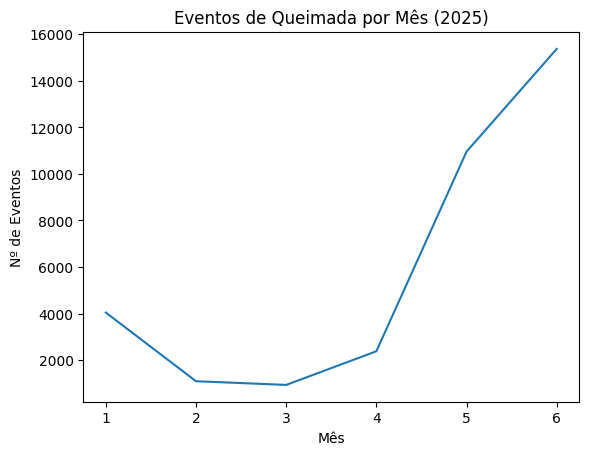

In [6]:
# contagem mensal de focos
mensal = df.groupby('mes').size().reset_index(name='count')

plt.figure()
plt.plot(mensal['mes'], mensal['count'])
plt.title('Eventos de Queimada por Mês (2025)')
plt.xlabel('Mês')
plt.ylabel('Nº de Eventos')
plt.xticks(mensal['mes'])
plt.show()

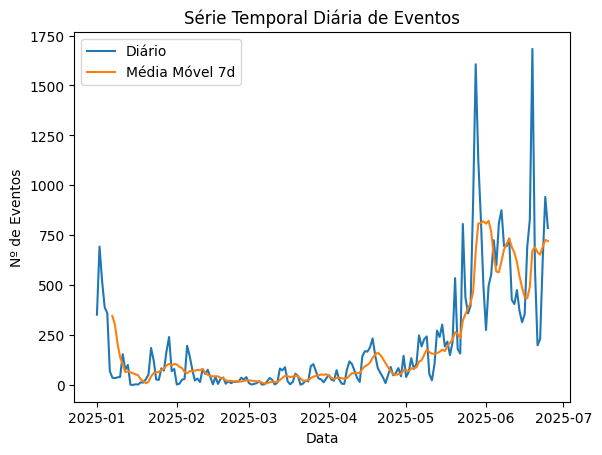

In [7]:
# Série diária (rolling 7 dias)
diario = df.set_index('data_hora_gmt').resample('D').size()
rol7   = diario.rolling(7).mean()

plt.figure()
plt.plot(diario.index, diario.values,     label='Diário')
plt.plot(rol7.index,   rol7.values,       label='Média Móvel 7d')
plt.title('Série Temporal Diária de Eventos')
plt.xlabel('Data')
plt.ylabel('Nº de Eventos')
plt.legend()
plt.show()

### Análise Geográfica

Top 10 municípios por Nº de Eventos:
 municipio
Balsas                 3556
Lagoa Do Mato          2873
Benedito Leite         2739
Mirador                1922
Carolina               1227
Parnarama              1076
São Félix De Balsas     993
Sambaíba                951
Barra Do Corda          911
Grajaú                  896
Name: count, dtype: int64


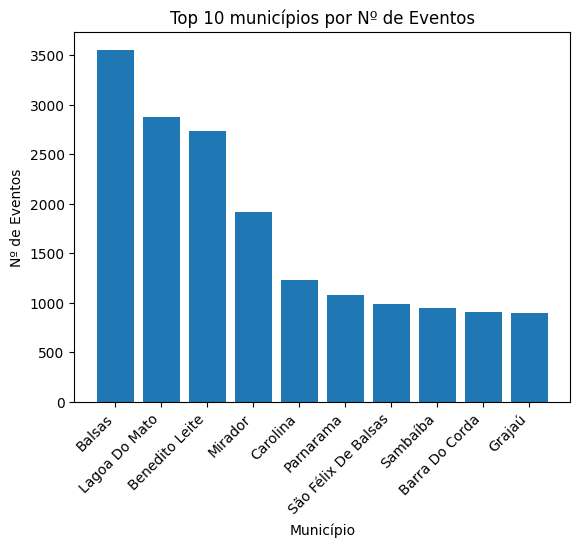

In [12]:
# Top 10 municípios por número de eventos
top_mun = df['municipio'].value_counts().nlargest(10)
print("Top 10 municípios por Nº de Eventos:\n", top_mun)

# Gráfico de barras
plt.figure()
plt.bar(top_mun.index.astype(str), top_mun.values)
plt.title('Top 10 municípios por Nº de Eventos')
plt.xlabel('Município')
plt.ylabel('Nº de Eventos')
plt.xticks(rotation=45, ha='right')
plt.show()

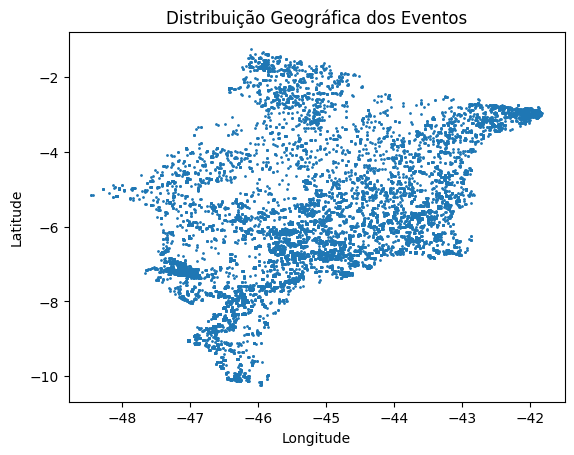

In [13]:
# Scatter geográfico
plt.figure()
plt.scatter(df['lon'], df['lat'], s=1)
plt.title('Distribuição Geográfica dos Eventos')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Correlações e Relações Entre Variáveis

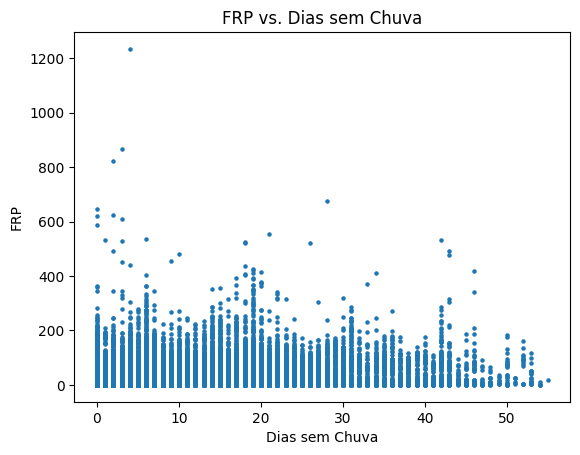

In [14]:
# FRP vs dias sem chuva
plt.figure()
plt.scatter(df['numero_dias_sem_chuva'], df['frp'], s=5)
plt.title('FRP vs. Dias sem Chuva')
plt.xlabel('Dias sem Chuva')
plt.ylabel('FRP')
plt.show()

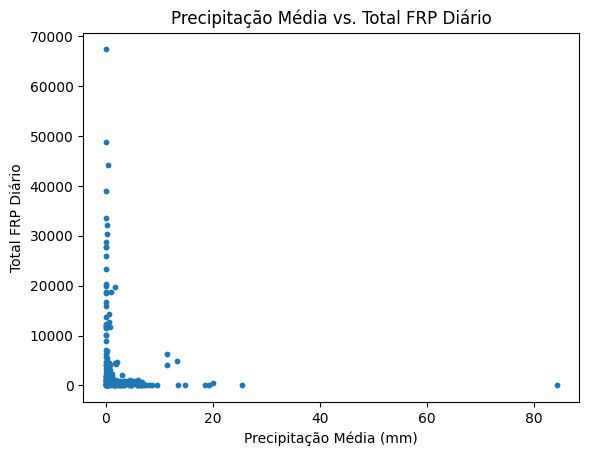

In [15]:
# Para precipitação vs eventos, primeiro agregue por dia
precip_diario = df.set_index('data_hora_gmt').resample('D').agg({
    'precipitacao': 'mean',
    'frp': 'sum'
})
plt.figure()
plt.scatter(precip_diario['precipitacao'], precip_diario['frp'], s=10)
plt.title('Precipitação Média vs. Total FRP Diário')
plt.xlabel('Precipitação Média (mm)')
plt.ylabel('Total FRP Diário')
plt.show()

### Principais Insights

1. **Mês com maior nº de eventos**  
   Junho (mês 6) registrou o maior volume de focos, com cerca de **15 500 eventos**, seguido por maio (≈11 000) e janeiro (≈4 000). Isso indica que a estação seca de final de outono/início de inverno concentra a maior atividade de queimadas.

2. **Município mais crítico**  
   Entre todos os municípios, **Balsas** lidera com **3 556 eventos**, seguido por Lagoa do Mato (2 873) e Benedito Leite (2 739). Esses três municípios juntos concentram uma parcela significativa dos focos no estado, sugerindo áreas prioritárias para monitoramento e prevenção.

3. **Correlação entre FRP e dias sem chuva**  
   - O scatter FRP × dias sem chuva mostra **distribuição ampla** sem uma relação linear forte, mas os maiores picos de FRP (acima de 800–1 200 MW) ocorrem geralmente em períodos com **menos de 10 dias sem chuva**.  
   - A análise precipitação média vs. total de FRP diário reforça que **altos valores de FRP** ocorrem quase sempre em dias com **precipitação muito baixa** (<5 mm), confirmando que as condições secas são um fator-chave na intensidade dos incêndios.